# Pairwise conservative kernel for multiple species

In [4]:
# import libraries
import theano
import theano.tensor as T
import theano.typed_list as Tl
from theano import function
from theano.compile.io import In
import numpy as np
import datetime

In [5]:
# remove the safety check to gain extra performance
#theano.config.optimizer = 'o3'

### Definitions

Define the position of the atoms relative to the centrla one, and their chemical species, by a matrix of dimension Mx5

In [6]:
# positions of central atoms
r1, r2 = T.dvectors('r1d','r2d') 
# positions of neighbours 
rho1, rho2 = T.dmatrices('rho1','rho2') 
# lengthscale hyperparameter
sig = T.dscalar('sig')
# cutoff hyperparameters
theta = T.dscalar('theta')
rc = T.dscalar('rc')

# positions of neighbours without chemical species (3D space assumed)
rho1s = rho1[:, 0:3]
rho2s = rho2[:, 0:3]
alpha_1 = rho1[:, 3:4].flatten()
alpha_2 = rho2[:, 3:4].flatten()
alpha_j = rho1[:, 4:5].flatten()
alpha_m = rho2[:, 4:5].flatten()


Calculate the relative distance to the central vector

In [7]:
# first configuration
r1j = T.sqrt(T.sum((rho1s[:, :]-r1[None,:])**2, axis = 1))
# second configuration
r2m = T.sqrt(T.sum((rho2s[:, :]-r2[None,:])**2, axis = 1))


Calculate the mask given by the chemical species

In [8]:
# numerical kronecker
def delta_alpha2(a1j, a2m):
    d = np.exp(-(a1j - a2m)**2/(2*(1e-5)**2))
    return d

delta_alpha2(100, 100)

1.0

In [9]:
delta_alphas12 = delta_alpha2(alpha_1[:, None] , alpha_2[None, :])
delta_alphasjm = delta_alpha2(alpha_j[:, None] , alpha_m[None, :])
delta_alphas1m = delta_alpha2(alpha_1[:, None] , alpha_m[None, :])
delta_alphasj2 = delta_alpha2(alpha_j[:, None] , alpha_2[None, :])

### Cutoff function

In [15]:
k_ij = (T.exp(-(r1j[:, None] - r2m[None,:])**2/sig) * (delta_alphas12 * delta_alphasjm + delta_alphas1m * delta_alphasj2))
k_ij = k_ij*(T.exp(-theta/(rc-r1j[:, None]))*T.exp(-theta/(rc-r2m[None,:])))/(T.exp(-theta/(rc-r1j[:, None]))*T.exp(-theta/(rc-r2m[None,:])))

# kernel
k = T.sum(k_ij)   

# energy energy kernel
k_ee_fun = function([r1, r2, rho1, rho2, sig, theta, rc], k, allow_input_downcast = True)

# energy force kernel
k_ef = T.grad(k, r2)
k_ef_fun = function([r1, r2, rho1, rho2, sig, theta, rc], k_ef, allow_input_downcast = True)

# force force kernel
k_ff = T.grad(k, r1)
k_ff_der, updates = theano.scan(lambda j, k_ff, r2 : T.grad(k_ff[j], r2), 
                                sequences = T.arange(k_ff.shape[0]), non_sequences = [k_ff, r2])

k_ff_fun = function([r1, r2, rho1, rho2, sig, theta, rc], k_ff_der, allow_input_downcast = True)


## Construction of kernels over lists of configurations

#### A simple example of a double for loop in Theano

In [17]:
# simple for loop 

a = T.scalar('a')
b = T.scalar('b')
prod = a*b
p_fun = function([a, b], prod)

list1, list2 = Tl.TypedListType(T.dscalar)('list1'), Tl.TypedListType(T.dscalar)('list2')
len1, len2 = Tl.length(list1), Tl.length(list2)
range1, range2 = T.arange(len1, dtype='int64'), T.arange(len2, dtype='int64')
mat = T.dmatrix('mat')

def fun2(j, e1, list2):
    return e1*list2[j]

def loop_over_list2(i, range2, list1, list2):
    
    e1 = list1[i]
    result_, updates_ = theano.scan(fn=fun2,
                              outputs_info = None,
                              non_sequences=[e1, list2],
                              sequences=[range2])
    return result_

result, updates = theano.scan(fn=loop_over_list2,
                              outputs_info = None,
                              non_sequences=[range2, list1, list2],
                              sequences=[range1])

f = theano.function(inputs=[list1, list2], outputs=result)

f([1, 2],[1, 3, 2])


array([[1., 3., 2.],
       [2., 6., 4.]])

### Define a symbolic "kernel" object and its derivative

In [18]:
def kernel_ee_(r1, r2, rho1, rho2, sig, theta, rc):
    rho1s = rho1[:, 0:3]
    rho2s = rho2[:, 0:3]
    alpha_1 = rho1[:, 3:4].flatten()
    alpha_2 = rho2[:, 3:4].flatten()
    alpha_j = rho1[:, 4:5].flatten()
    alpha_m = rho2[:, 4:5].flatten()
    r1j = T.sqrt(T.sum((rho1s[:, :]-r1[None,:])**2, axis = 1))
    r2m = T.sqrt(T.sum((rho2s[:, :]-r2[None,:])**2, axis = 1))
    delta_alphas12 = delta_alpha2(alpha_1[:, None] , alpha_2[None, :])
    delta_alphasjm = delta_alpha2(alpha_j[:, None] , alpha_m[None, :])
    delta_alphas1m = delta_alpha2(alpha_1[:, None] , alpha_m[None, :])
    delta_alphasj2 = delta_alpha2(alpha_j[:, None] , alpha_2[None, :])
    k_ij = (T.exp(-(r1j[:, None] - r2m[None,:])**2/sig) * (delta_alphas12 * delta_alphasjm + delta_alphas1m * delta_alphasj2)
    *T.exp(-theta/(rc-r1j[:, None]))*T.exp(-theta/(rc-r2m[None,:])))
    k = T.sum(k_ij) 
    return k


def kernel_ef_(r1, r2, rho1, rho2, sig, theta, rc):
    k = kernel_ee_(r1, r2, rho1, rho2, sig, theta, rc)
    k_ef = T.grad(k, r2)

    return k_ef


def kernel_ff_(r1, r2, rho1, rho2, sig, theta, rc):
    k = kernel_ee_(r1, r2, rho1, rho2, sig, theta, rc)
    k_ff_der = T.grad(k, r1)
    k_ff, updates = theano.scan(lambda j, k_ff, r2 : T.grad(k_ff_der[j], r2), 
                                sequences = T.arange(k_ff_der.shape[0]), non_sequences = [k_ff_der, r2])

    return k_ff

### Define symbolic functions that loop over elements of a list

In [19]:
def fun_ee(j, e1, list2, r1, r2, sig, theta, rc):
    return kernel_ee_(r1, r2, e1, list2[j], sig, theta, rc)


def fun_ff(j, e1, list2, r1, r2, sig, theta, rc):
    return kernel_ff_(r1, r2, e1, list2[j], sig, theta, rc)


def fun_ef(j, e1, list2, r1, r2, sig, theta, rc):
    return kernel_ef_(r1, r2, e1, list2[j], sig, theta, rc)


def loop_over_list_ee(i, range2, list1, list2, r1, r2, sig, theta, rc):
    e1 = list1[i]
    result_, updates_ = theano.scan(fn=fun_ee,
                              outputs_info = None,
                              non_sequences=[e1, list2, r1, r2,  sig, theta, rc],
                              sequences=[range2])
    return result_


def loop_over_list_ef(i, range2, list1, list2, r1, r2, sig, theta, rc):
    e1 = list1[i]
    result_, updates_ = theano.scan(fn=fun_ef,
                              outputs_info = None,
                              non_sequences=[e1, list2, r1, r2, sig, theta, rc],
                              sequences=[range2])
    return result_


def loop_over_list_ff(i, range2, list1, list2, r1, r2, sig, theta, rc):
    e1 = list1[i]
    result_, updates_ = theano.scan(fn=fun_ff,
                              outputs_info = None,
                              non_sequences=[e1, list2, r1, r2, sig, theta, rc],
                              sequences=[range2])
    return result_

### Define two list of configurations and the final functions

In [20]:
# define lists of configurations to loop over (lists of matrices)

rho1l = Tl.TypedListType(T.dmatrix)('rho1l')
rho2l = Tl.TypedListType(T.dmatrix)('rho2l')

l1, l2 = Tl.length(rho1l), Tl.length(rho2l)
range1, range2 = T.arange(l1, dtype='int64'), T.arange(l2, dtype='int64')


In [23]:
# lengths of the two lists

result, updates = theano.scan(fn=loop_over_list_ee,
                              outputs_info = None,
                              non_sequences=[range2, rho1l, rho2l, r1, r2, sig, theta, rc],
                              sequences=[range1])

k_ee_func_for = function(inputs=[r1, r2, rho1l, rho2l,  sig, theta, rc], outputs=result,  allow_input_downcast = True)


In [25]:

result, updates = theano.scan(fn=loop_over_list_ef,
                              outputs_info = None,
                              non_sequences=[range2, rho1l, rho2l, r1, r2, sig, theta, rc],
                              sequences=[range1])

k_ef_func_for = function(inputs=[r1, r2, rho1l, rho2l,  sig, theta, rc], outputs=result,  allow_input_downcast = True)


In [27]:

result, updates = theano.scan(fn=loop_over_list_ff,
                              outputs_info = None,
                              non_sequences=[range2, rho1l, rho2l, r1, r2, sig, theta, rc],
                              sequences=[range1])

k_ff_func_for = function(inputs=[r1, r2, rho1l, rho2l, sig, theta, rc]
                         , outputs=result,allow_input_downcast = True)

### Saving the kernels

In [15]:
from six.moves import cPickle
import sys

sys.setrecursionlimit(3000)
# local kernels (over two configurations)
f = open('2B_ms_ee.save', 'wb')
cPickle.dump(k_ee_fun, f, protocol=cPickle.HIGHEST_PROTOCOL)
f.close()

f = open('2B_ms_ef.save', 'wb')
cPickle.dump(k_ef_fun, f, protocol=cPickle.HIGHEST_PROTOCOL)
f.close()

f = open('2B_ms_ff.save', 'wb')
cPickle.dump(k_ff_fun, f, protocol=cPickle.HIGHEST_PROTOCOL)
f.close()

# global kernels (over two lists configurations)
f = open('2B_ms_for_ee.save', 'wb')
cPickle.dump(k_ee_func_for, f, protocol=cPickle.HIGHEST_PROTOCOL)
f.close()

f = open('2B_ms_for_ef.save', 'wb')
cPickle.dump(k_ef_func_for, f, protocol=cPickle.HIGHEST_PROTOCOL)
f.close()

f = open('2B_ms_for_ff.save', 'wb')
cPickle.dump(k_ff_func_for, f, protocol=cPickle.HIGHEST_PROTOCOL)
f.close()

## Tests

Test on a single configuration

In [28]:
rho1n = np.array([[1, 2, 3, 1, 3],
                  [1, 2, 4, 1, 4],
                  [1, 2, 1, 1, 1]])

rho2n = np.array([[1.2, 2.1, 3.3, 1, 3],
                  [1.7, 2.1, 4.6, 1, 4],
                  [1.2, 2.1, 1.2, 1, 1]])

print(rho1n.shape, rho2n.shape)

(3, 5) (3, 5)


In [29]:
mat = k_ff_fun(np.array([0,0,0]), np.array([0,0,0]), rho1n, rho2n, 100., 1., 1.)
matT = k_ff_fun(np.array([0,0,0]), np.array([0,0,0]),rho2n, rho1n, 100., 1., 1.)


In [30]:
print(mat)
print(np.isclose(mat,matT.T))

[[0.01017333 0.01709959 0.01523917]
 [0.02034665 0.03419917 0.03047834]
 [0.01739906 0.02763341 0.03492898]]
[[ True  True  True]
 [ True  True  True]
 [ True  True  True]]


Tests on random configurations

In [31]:
np.set_printoptions(precision=4)

In [47]:
# create random configurations

n1 = 100
n2 = 100
d = 3 # this can't be changed
nn = 12
confs1 = (np.random.rand(n1, nn, d+2)-0.5)*100
confs2 = (np.random.rand(n2, nn, d+2)-0.5)*100

confs1[:, :, 3:5] = 1.
confs2[:, :, 3:5] = 1.

In [56]:

ti_python = datetime.datetime.now()
gram = np.zeros((n1*d,n2*d))
for i in np.arange(n1):
    for j in np.arange(n2):
        gram[d*i:d*(i+1),d*j:d*(j+1)] = k_ff_fun(np.zeros(d),np.zeros(d), 
                                                 confs1[i],confs1[j], 10000., 1., 1000.)

tf_python = datetime.datetime.now()
(tf_python-ti_python).total_seconds()


4.100166

In [57]:
ti_theano = datetime.datetime.now()
gram_for = k_ff_func_for(np.zeros(d),np.zeros(d), confs1, confs1,  10000., 1., 1000.)
gram_for = np.reshape(gram_for.swapaxes(1, 2), (gram_for.shape[0]*gram_for.shape[2], gram_for.shape[1]*gram_for.shape[2]))
tf_theano = datetime.datetime.now()
(tf_theano-ti_theano).total_seconds()

2.102414

In [58]:
print(np.allclose(gram_for,gram))

False


-9.63314991921403e-17
0.42955587967506403


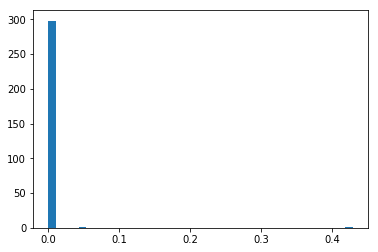

In [59]:
import matplotlib.pyplot as plt
eigs, eigvecs = np.linalg.eigh(gram)
print(np.min(eigs))
print(np.max(eigs))
plt.hist(eigs[:], 40)
plt.show()

In [60]:
print(theano.config.optimizer)
print(theano.config.linker)
print(theano.config.mode)

o3
cvm
Mode
